# Project Goals:

The goals of our project were to draw conclusions and provide insight to our clients about the aviation industry. Our clients were specifically interested in the business potential of airplanes. We were tasked with analyzing data from the FAA containing report records of accidents and incidents from all types of aircrafts. Using the information from these reports, we were able to determine several airplanes to be worthy of recommendation in three separate sectors of the aviation industry.

In [86]:
# import dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
%matplotlib inline

#  Cleaning the Dataset:

In [87]:
# import main csv
df = pd.read_csv('data/Aviation_Data.csv', low_memory=False)
print(f'Original df.shape -> {df.shape}')

Original df.shape -> (90348, 31)


### Removing non-Airplanes:
Stakeholders were only interested in airplanes.

In [88]:
# replace null Aircraft.Category values with "Unknown"
df['Aircraft.Category'] = df['Aircraft.Category'].fillna('Unknown')

# drop non-Airplanes
df = df[df['Aircraft.Category'].isin(['Airplane', 'Unknown'])]
print(f'After dropping non-airplanes, df.shape -> {df.shape}')

After dropping non-airplanes, df.shape -> (85692, 31)


### Dropping null rows we found from exploration:

In [89]:
# drop null rows
null_rows = df[df['Event.Id'].isna()]
df = df.drop(null_rows.index)

# more null rows
more_null_rows = df[df['Injury.Severity'] == 'Unavailable']
df = df.drop(more_null_rows.index)

print(f'After dropping {null_rows.shape[0] + more_null_rows.shape[0]} null rows, df.shape -> {df.shape}')

After dropping 1552 null rows, df.shape -> (84140, 31)


### Only keep data from 2003-2022:
We felt that data from the past twenty years would be most pertinent to our clients. That information would reflect a post-9/11 set of aviation rules and regulations. We also felt our clients would be more interested in modern airplanes with updated technology as opposed to collector or historical planes which were more likely to be referenced in older records.

In [90]:
# drop null years
df = df.dropna(subset=['Event.Date'])

# add year column, convert to int
df['year'] = df['Event.Date'].str[:4].astype(int)

# only keep data from last 20 years
df = df[df['year'] >= 2003]

print(f'Records from last 20 years, df.shape -> {df.shape}')

Records from last 20 years, df.shape -> (30700, 32)


### Dropping unused columns:

In [91]:
# drop columns we did not use
cols = ['Event.Id', 'Accident.Number', 'Latitude', 'Longitude', 'Airport.Code', 'Airport.Name', 'Registration.Number', 
              'Amateur.Built', 'FAR.Description', 'Schedule', 'Air.carrier', 'Report.Status', 'Publication.Date']
df = df.drop(cols, axis=1)

# rename remaining columns
df.columns = [col.strip().lower().replace('.', '_') for col in df.columns]

print(f'After dropping {len(cols)} columns, df.shape -> {df.shape}')

After dropping 13 columns, df.shape -> (30700, 19)


### Dealing with null values:
We replaced null values in numeric columns with 0. We debated on using a measure of central tendency (mean, median), but those values were so close to zero that we decided to use 0 instead.
We replaced null values in non-numeric columns with "Unknown".

In [92]:
# replace null values in numerical columns with 0
for col in ['number_of_engines', 'total_fatal_injuries', 'total_serious_injuries',
       'total_minor_injuries', 'total_uninjured']:
    df[col] = df[col].fillna(0)
    df[col] = df[col].astype(int)
    
# replace null values in non-numerical columns
df = df.fillna('Unknown')

print('Cleaned df Null values:\n')
print(df.isna().sum())

Cleaned df Null values:

investigation_type        0
event_date                0
location                  0
country                   0
injury_severity           0
aircraft_damage           0
aircraft_category         0
make                      0
model                     0
number_of_engines         0
engine_type               0
purpose_of_flight         0
total_fatal_injuries      0
total_serious_injuries    0
total_minor_injuries      0
total_uninjured           0
weather_condition         0
broad_phase_of_flight     0
year                      0
dtype: int64


### Condense "make" and "model" columns:

In [93]:
# take first 2 words from each "make"
df['make'] = df['make'].str.split().apply(lambda x: ' '.join(x[:2]) if len(x) > 1 else ' '.join(x))

# remove whitespace, turn all "makes" and "models" to titlecase
df['make'] = df['make'].str.strip().str.title()
df['model'] = df['model'].str.strip().str.title()

# remove dashes from "model" column
df['model'] = df['model'].str.replace('-', '')

# create unique make_model column for each specific airplane
df['make_model'] = df['make'] + ' ' + df['model']

### Create column for calculating fatality rates:

In [94]:
# remap injury_severity column to binary value
df['injury_severity'] = df['total_fatal_injuries'].apply(lambda x: 'fatal' if x > 0 else 'non-fatal')

print(f'Final df.shape -> {df.shape}')

Final df.shape -> (30700, 20)


# Methods

We focused on just over 100 different airplanes that appeared most often in our data. We focused primarily on fatality rates, injury severity, weather resistance, and aircraft structural resilience in order to determine our strongest recommendations in each sector.

We conducted EDA on this data, and manipulated it to reveal insights on each of these 3 categories:

- Small private planes
- Large commercial planes
- Aerial-application (work )planes

## 1. Private Aircraft:

With the majoity of our dataset being small/private planes, we decided to narrow down this pool to the 100 models with the most data. Below illustrates the process of creating a dataframe that captures the statistics of these 100 models.

#### Number of unique models:
Out of the 30700 records that we had, we decided to take a look at the unique model counts.

In [95]:
# create df to store each unique airplane, number of times it occurred in original df
model_counts = df.groupby(['make', 'model']).size().reset_index(name='count')

print(f'Number of unique models in entire df: {model_counts.shape[0]}')

Number of unique models in entire df: 8108


In [96]:
# models that have more than 50 flights
more_than_50 = model_counts[model_counts['count'] >= 50]

print(f'There are {more_than_50.shape[0]} models with more than 50 accident reports. The 50/{model_counts.shape[0]} top')
print(f'models represent {more_than_50["count"].sum()/model_counts["count"].sum()*100:.1f}% of the 30,700 accident reports.')

There are 96 models with more than 50 accident reports. The 50/8108 top
models represent 35.8% of the 30,700 accident reports.


#### 8108 models - too many to evaluate:
As you can see above, 96 models had more than 50 accident reports. We felt like 50 flights was an adequate sample size of accident data to evaluate each individual model. We rounded this number up to 100 for simplicity (Housing more than 36% of total reports). This allowed us to focus on planes in which we felt like we had an adequate amount of data (at least )

In [97]:
# get top 100 models
top_100_models = model_counts.sort_values(by='count', ascending=False).head(100)

# create a make_model column for full name
top_100_models['make_model'] = top_100_models['make'] + ' ' +  top_100_models['model']

print(f'Top 100 models represent {top_100_models["count"].sum()/model_counts["count"].sum()*100:.1f}% of the 30,700 accident reports.')

Top 100 models represent 36.4% of the 30,700 accident reports.


#### Add aggregated data to top_100_models:
- Fatality rate
- Average injuries per crash (Fatal, Serious, Minor)
- Damage distrubution (Destroyed, Substantial, Minor)

In [98]:
# function to calculate fatality rate
def compute_fatality_rate(model, df):
    value_counts = df[df['model'] == model]['injury_severity'].value_counts()
    
    # return zero if no 'fatal' counts
    return value_counts.get('fatal', 0) / value_counts.sum()

# create fatality_rate column from injury_severity percentages
top_100_models['fatality_rate'] = top_100_models['model'].map((lambda model: compute_fatality_rate(model, df)))

In [99]:
# add total injuries per model
for col in ['total_fatal_injuries', 'total_serious_injuries', 'total_minor_injuries', 'total_uninjured']:
    top_100_models[col] = top_100_models['model'].map(lambda model_name: 
                                         df[df['model'] == model_name][col].sum())

# add avg injuries per crash
for col in ['avg_fatal_injuries', 'avg_serious_injuries', 'avg_minor_injuries', 'avg_uninjured']:
    top_100_models[col] = top_100_models['total'+col[3:]] / top_100_models['count']

In [100]:
# function to get normalized aircraft_damage value counts for each model
def get_damage_distribution(model):
    df_new = df[df['model'] == model]
    return df_new['aircraft_damage'].value_counts(normalize=True)

# adding normalized damage distributions for each model
damage_df = top_100_models['model'].apply(get_damage_distribution)
top_100_models = pd.concat([top_100_models, damage_df], axis=1)

#### Add num_seats:
To classify planes based on size.

In [101]:
# rough estimates
num_seats = {'Boeing 777': 400,'Boeing 767': 250,'Boeing 747': 416,'Boeing 737': 160,'Cessna 182A': 4,'Airbus A320': 186,
                  'Stinson 108': 4,'Piper Pa18150': 2,'Cessna 120': 2,'Piper Pa22': 4,'Piper Pa18': 2,'Cessna 180': 4,
                  'Cessna 170': 4,'Piper Pa22150': 2,'Luscombe 8A': 2,'Cessna 140': 2,'Cessna 170B': 4,'Piper J3C65': 2,
                  'Air Tractor At301': 1,'Cessna 152': 2,'Cessna 172P': 4,'Piper Pa 18150': 2,'Luscombe 8': 2,'Cessna 172Rg': 4,
                  'Cessna A185': 6,'Aeronca 7Ac': 2,'Air Tractor At502B': 1,'Cessna 172R': 4,'Cessna 172S': 4,'Cessna 150G': 2,
                  'Beech C23': 4,'Piper Pa12': 2,'Piper Pa28161': 4,'Cessna A185F': 6,'Cessna 172K': 4,'Cessna 185': 6,
                  'Cessna 172M': 4,'Cessna 150L': 2,'Cessna 172H': 4,'Cessna 177': 4,'Cessna 150F': 2,'Cessna T210L': 6,
                  'Cessna 172N': 4,'Cessna R182': 4,'Cessna 172': 4,'Piper Pa28151': 4,'Beech 35': 6,'Piper Pa24': 4,
                  'Cessna 177Rg': 4,'Bellanca 7Gcbc': 2,'Cessna A188B': 1,'Cessna P210N': 6,'Cessna 150M': 2,'Bell 206B': 5,
                  'Piper Pa28180': 4,'Cessna 182P': 4,'Cessna T210M': 6,'Cessna 150': 2,'Piper Pa44180': 8,'Piper Pa28': 4,
                  'Piper Pa28140': 4,'Piper Pa38112': 6,'Piper Pa28235': 4,'Piper Pa32': 6,'Cessna 182': 4,'Cessna T210N': 6,
                  'Mooney M20E': 4,'Piper Pa28R': 4,'Air Tractor At602': 1,'Piper Pa46': 6,'Air Tractor At502': 1,
                  'Piper Pa24250': 6,'Piper Pa28181': 4,'Cessna 206': 6,'Piper Pa31350': 6,'Cessna U206G': 6,'Cessna 210': 6,
                  'Piper Pa28R200': 4,'Cessna 208B': 14,'Mooney M20C': 4,'Mooney M20J': 4,'Piper Pa25235': 6,'Cessna T210': 6,
                  'Piper Pa32300': 6,'Cirrus Design Sr20': 4,'Cessna 182Q': 4,'Piper Pa32260': 6,'Cirrus Sr22': 5,
                  'Cirrus Design Sr22': 5, 'Beech V35B': 6,'Cessna 208': 14,'Beech A36': 6,'Cessna U206': 6,'Piper Pa30': 4,
                  'Piper Pa32R300': 6,'Piper Pa34200T': 7,'Beech 58': 6,'Piper Pa23250': 6,'Piper Pa34': 6,'Robinson R44': 4}

# create num_seats column
top_100_models['num_seats'] = top_100_models['make_model'].map(num_seats)

# Private Aircrafts:
We used inferential statistics to evaluate small planes with the most data using the top_100_models of which 94 were small planes

In [102]:
Top_100_models = pd.read_csv("./data/top_100_models.csv")

Filtered data to include only small planes in the rage of 6 to 20

In [104]:
df_filtered = Top_100_models[(Top_100_models['num_seats'] >= 6) & (Top_100_models['num_seats'] <= 20)]

# Fatality Rate by Make:
From the unique makes with largest dataset we compared makes by fatality rate

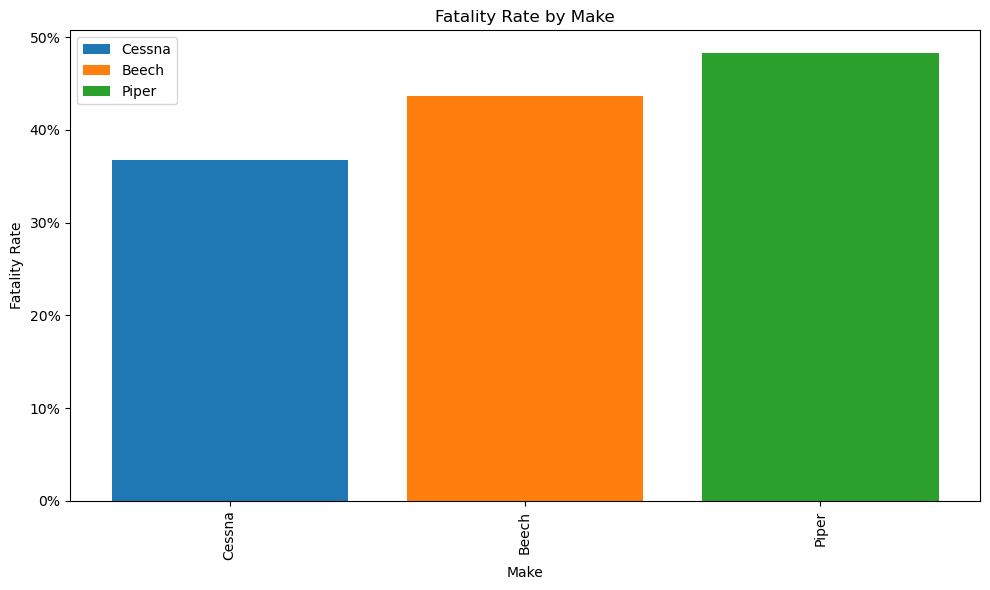

In [105]:
#finds the unique makes from the sample size 
unique_makes = df_filtered['make'].unique()

fig, ax = plt.subplots(figsize=(10, 6))

#Creates a lopp to assign each make from the unique makes
for make in unique_makes:
    make_data = df_filtered[df_filtered['make'] == make]
    
    ax.bar(make_data['make'], make_data['fatality_rate'] * 100, label=make)  # Multiply y-values by 100
#Plot the graph, mortality rate of each make  
ax.set_xlabel('Make')
ax.set_ylabel('Fatality Rate')
ax.set_title('Fatality Rate by Make')
ax.legend()

# Format y-axis as percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Injury Severity And Aircraft Damage
We used the severity rate of injuries and the overall rate of accident injury and Aircraft Damage to access wich model from the makes above are the safest or with least number of injury as well as severity

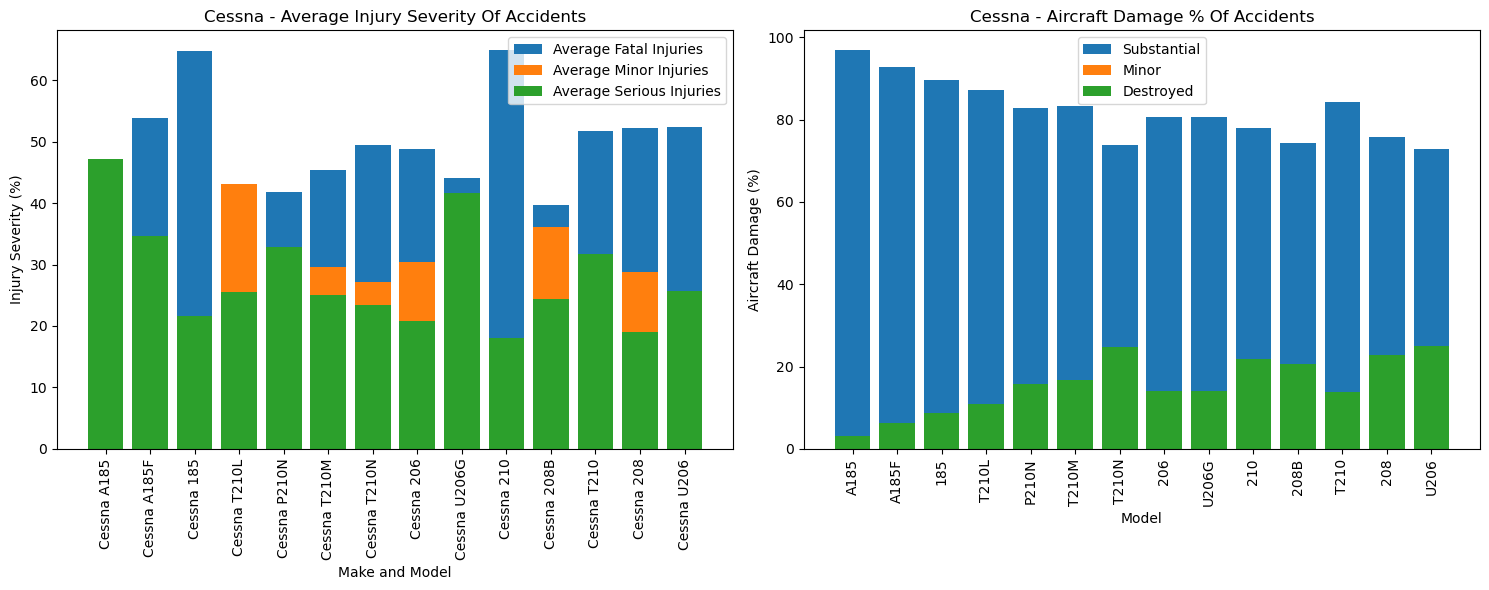

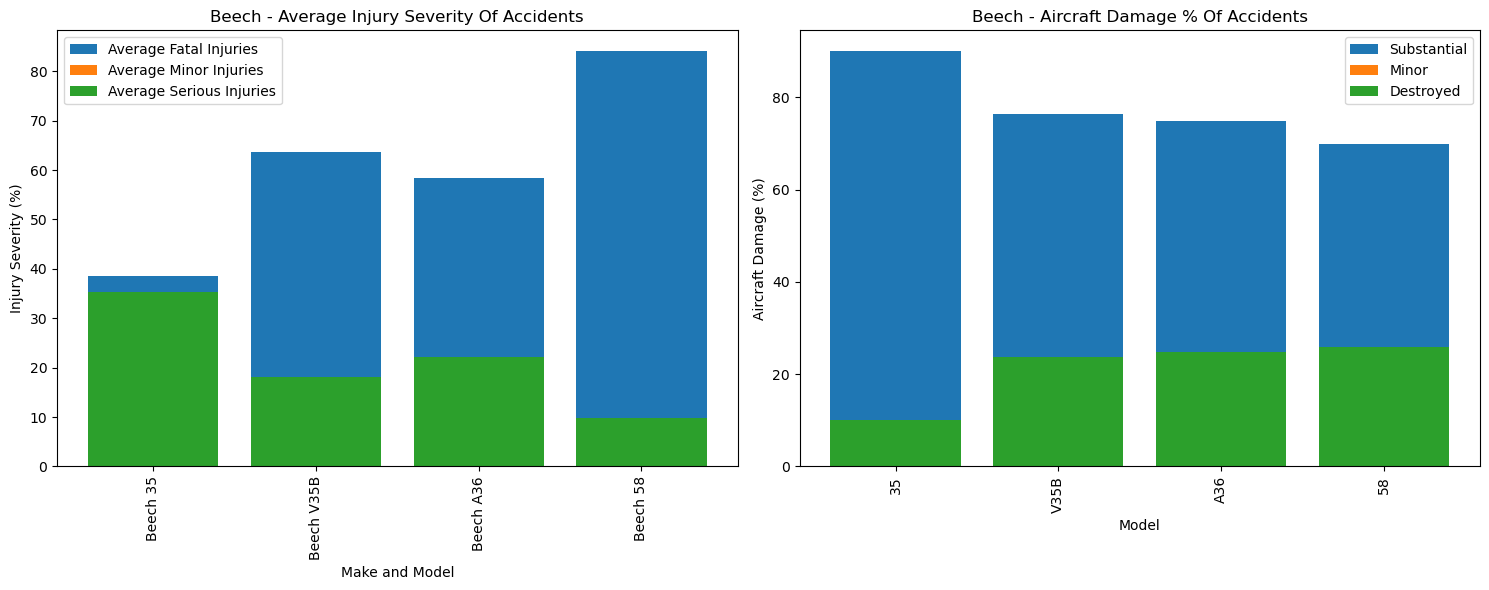

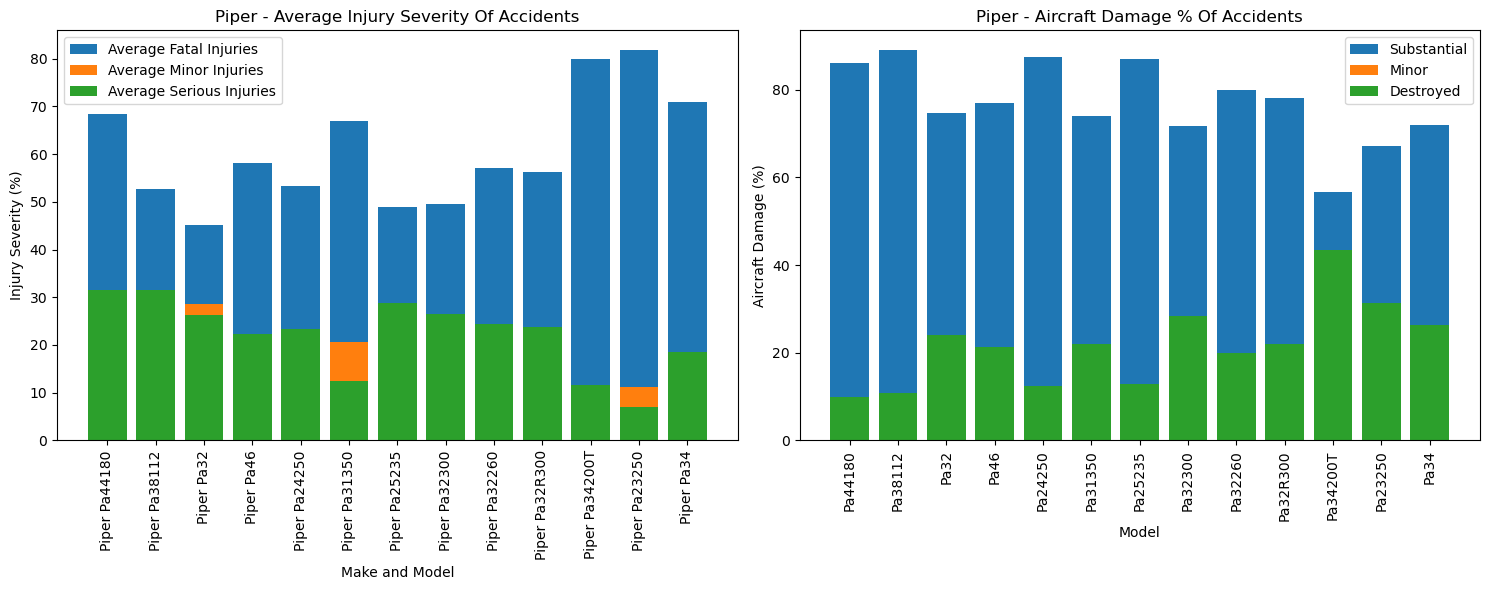

In [106]:
#filters the unique makes from the sample size 
unique_makes = df_filtered['make'].unique()
#Creates a lopp to assign each make from the unique makes 
for make in unique_makes:
    make_data = df_filtered[df_filtered['make'] == make]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # First subplot
    total_injuries = make_data[['avg_fatal_injuries', 'avg_minor_injuries', 'avg_serious_injuries']].sum(axis=1)
    normalized_injuries = make_data[['avg_fatal_injuries', 'avg_minor_injuries', 'avg_serious_injuries']].div(total_injuries, axis=0) * 100
    ax1.bar(make_data['make'] + ' ' + make_data['model'], normalized_injuries['avg_fatal_injuries'], label='Average Fatal Injuries')
    ax1.bar(make_data['make'] + ' ' + make_data['model'], normalized_injuries['avg_minor_injuries'], label='Average Minor Injuries')
    ax1.bar(make_data['make'] + ' ' + make_data['model'], normalized_injuries['avg_serious_injuries'], label='Average Serious Injuries')
    ax1.set_xlabel('Make and Model')
    ax1.set_ylabel('Injury Severity (%)')
    ax1.set_title(f'{make} - Average Injury Severity Of Accidents')
    ax1.set_xticks(make_data['make'] + ' ' + make_data['model'])
    ax1.set_xticklabels(make_data['make'] + ' ' + make_data['model'], rotation=90)
    ax1.legend()

    # Second subplot
    total_damage = make_data[['Substantial', 'Minor', 'Destroyed']].sum(axis=1)
    normalized_damage = make_data[['Substantial', 'Minor', 'Destroyed']].div(total_damage, axis=0) * 100
    ax2.bar(make_data['model'], normalized_damage['Substantial'], label='Substantial')
    ax2.bar(make_data['model'], normalized_damage['Minor'], label='Minor')
    ax2.bar(make_data['model'], normalized_damage['Destroyed'], label='Destroyed')
    ax2.set_xlabel('Model')
    ax2.set_ylabel('Aircraft Damage (%)')
    ax2.set_title(f'{make} - Aircraft Damage % Of Accidents')
    ax2.set_xticks(make_data['model'])
    ax2.set_xticklabels(make_data['model'], rotation=90)
    ax2.legend()

    plt.tight_layout()
    plt.show()

## Model and Make Assesment:
From the above analysis we chose these three models to compete in the larger data set to get a more accurate presentation.
Fatality rate show's that Cessna208B and Beech 35 are the best options.

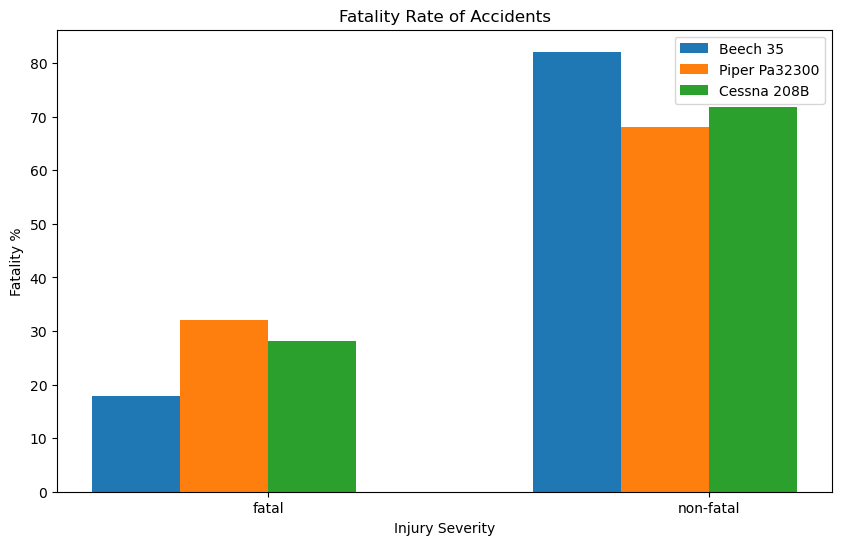

In [112]:
#assigned which model and make we'll compete from the above data
make1 = 'Beech'
model1 = '35'
make2 = 'Piper'
model2 = 'Pa32300'
make3 = 'Cessna'
model3 = '208B'

#assigned each make and column to a variable 
make1_model1_data = df[(df['make'] == make1) & (df['model'] == model1)]
make2_model2_data = df[(df['make'] == make2) & (df['model'] == model2)]
make3_model3_data = df[(df['make'] == make3) & (df['model'] == model3)]

#Found the total severity of the values 
total1 = make1_model1_data['injury_severity'].value_counts().sum()
total2 = make2_model2_data['injury_severity'].value_counts().sum()
total3 = make3_model3_data['injury_severity'].value_counts().sum()

#assigned the catagories within the injury column
categories = ['fatal', 'non-fatal']
bar_width = 0.2

#plot
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(np.arange(len(categories)), (make1_model1_data['injury_severity'].value_counts().reindex(categories, fill_value=0) / total1) * 100, bar_width, label=f'{make1} {model1}')
bar2 = ax.bar(np.arange(len(categories)) + bar_width, (make2_model2_data['injury_severity'].value_counts().reindex(categories, fill_value=0) / total2) * 100, bar_width, label=f'{make2} {model2}')
bar3 = ax.bar(np.arange(len(categories)) + 2 * bar_width, (make3_model3_data['injury_severity'].value_counts().reindex(categories, fill_value=0) / total3) * 100, bar_width, label=f'{make3} {model3}')

ax.set_xlabel('Injury Severity')
ax.set_ylabel('Fatality %')
ax.set_title(f'Fatality Rate of Accidents')
ax.set_xticks(np.arange(len(categories)) + 1.5 * bar_width)
ax.set_xticklabels(categories)
ax.legend()

plt.show()

## Aircraft Damage:
From the models we picked we assesed aircraft damage and found Beech 35, which is our top choice has less damage from the accidents reported. 

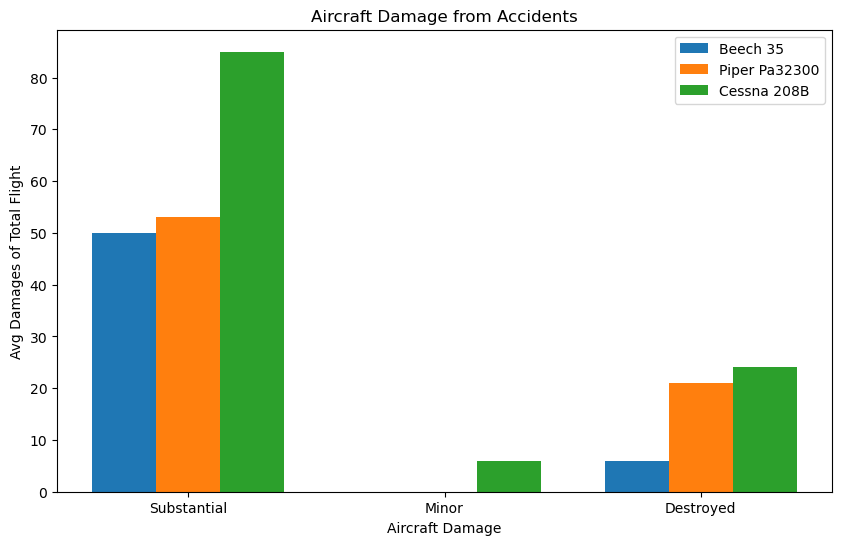

In [117]:
#assigned which model and make we'll compete from the above data
make1 = 'Beech'
model1 = '35'
make2 = 'Piper'
model2 = 'Pa32300'
make3 = 'Cessna'
model3 = '208B'

#assigned each make and column to a variable 
make1_model1_data = df[(df['make'] == make1) & (df['model'] == model1)]
make2_model2_data = df[(df['make'] == make2) & (df['model'] == model2)]
make3_model3_data = df[(df['make'] == make3) & (df['model'] == model3)]

#assigned the catagories within the injury column
categories = ['Substantial', 'Minor', 'Destroyed']
bar_width = 0.25

#Creates a set of bar plots 
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(np.arange(len(categories)), make1_model1_data['aircraft_damage'].value_counts().reindex(categories, fill_value=0), bar_width, label=f'{make1} {model1}')
bar2 = ax.bar(np.arange(len(categories)) + bar_width, make2_model2_data['aircraft_damage'].value_counts().reindex(categories, fill_value=0), bar_width, label=f'{make2} {model2}')
bar3 = ax.bar(np.arange(len(categories)) + 2 * bar_width, make3_model3_data['aircraft_damage'].value_counts().reindex(categories, fill_value=0), bar_width, label=f'{make3} {model3}')

ax.set_xlabel('Aircraft Damage')
ax.set_ylabel('Avg Damages of Total Flight')
ax.set_title(f'Aircraft Damage from Accidents')
ax.set_xticks(np.arange(len(categories)) + bar_width)
ax.set_xticklabels(categories)
ax.legend()

plt.show()

## Results:

After narrowing down to create a sample size with most appearnce
We found the makes and analyzed each mode with it's corresponding model
Leading us to a ## Beech 35 with fatality rate of 0.17 
And ## Cessna 208B as our second best choice with a fatality rate of 0.28.

## 2. Commercial Aircraft:

We found through extensive EDA (and prior domain knowledge) that the top 2 "large" aircraft manufacturers were Boeing and Airbus. With this knowledge, we evaluated the Boeing and Airbus models with the most quality data.

#### Get Boeing and Airbus rows

In [ ]:
boeing_rows = df[df['make'] == 'Boeing']
airbus_rows = df[df['make'] == 'Airbus']

print(f'Num of Boeing accident reports: {boeing_rows.shape[0]}')
print(f'Num of Airbus accident reports: {airbus_rows.shape[0]}')

#### Compare fatality rate per manufacturer:
We found that Boeing and Airbus only differed by 0.1%.

In [ ]:
boeing_fatality = boeing_rows['injury_severity'].value_counts(normalize=True)[1]
airbus_fatality = airbus_rows['injury_severity'].value_counts(normalize=True)[1]

print(f'Boeing fatality rate: {boeing_fatality*100:.1f}%')
print(f'Airbus fatality rate: {airbus_fatality*100:.1f}%')

#### Comparing aircraft damage as a result of weather condition:
VMC (visible conditions): Airbus slightly edged Boeing in overall performance. Airbus boasted an impressive 0% "Destroyed" proportion.

IMC (poor conditions - cloud/fog): Inconclusive results. Boeing and Airbus displayed similar results in inclement weather conditions.

In [ ]:
# only keep VMC/IMC weather vals
weather_boeing = boeing_rows[boeing_rows['weather_condition'].isin(['VMC', 'IMC'])]
weather_airbus = airbus_rows[airbus_rows['weather_condition'].isin(['VMC', 'IMC'])]

In [ ]:
# VMC (clear) weather
vmc_boeing = weather_boeing[weather_boeing['weather_condition'] == 'VMC']
vmc_airbus = weather_airbus[weather_airbus['weather_condition'] == 'VMC']

# drop "unknown" aircraft_damage vals
vmc_boeing = vmc_boeing[vmc_boeing['aircraft_damage'] != 'Unknown']
vmc_airbus = vmc_airbus[vmc_airbus['aircraft_damage'] != 'Unknown']

# get counts for each damage category - Boeing
boeing_counts = vmc_boeing['aircraft_damage'].value_counts(normalize=True).reset_index()
boeing_counts.columns = ['aircraft_damage', 'proportion']
boeing_counts['company'] = 'Boeing'

# get counts for each damage category - Airbus
airbus_counts = vmc_airbus['aircraft_damage'].value_counts(normalize=True).reset_index()
airbus_counts.columns = ['aircraft_damage', 'proportion']
airbus_counts['company'] = 'Airbus'

# combine dfs to plot
combined = pd.concat([boeing_counts, airbus_counts])

# custom order for hue
damage_order = ['Minor', 'Substantial', 'Destroyed']

# plot
fig, ax = plt.subplots(figsize=(12, 8))
plot = sns.barplot(data=combined, x='company', y='proportion', hue='aircraft_damage', ax=ax, palette='Reds',
                   hue_order=damage_order)

ax.set_title('Aircraft Damage in Visible Conditions', fontsize=24)
ax.legend(loc='upper right')

# y-axis ticks/labels
locations = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
labels = ['0%', '10%', '20%', '30%', '40%', '50%', '60%']
ax.set_yticks(locations)
ax.set_yticklabels(labels)
ax.set_ylabel('Proportion', fontsize=16)

# y-axis ticks/labels
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16);

In [ ]:
# IMC (vmc) weather
inc_boeing = weather_boeing[weather_boeing['weather_condition'] == 'IMC']
inc_airbus = weather_airbus[weather_airbus['weather_condition'] == 'IMC']

# drop "unknown" aircraft_damage vals
inc_boeing = inc_boeing[inc_boeing['aircraft_damage'] != 'Unknown']
inc_airbus = inc_airbus[inc_airbus['aircraft_damage'] != 'Unknown']

# get counts for each damage category - Boeing
boeing_counts = vmc_boeing['aircraft_damage'].value_counts(normalize=True).reset_index()
boeing_counts.columns = ['aircraft_damage', 'proportion']
boeing_counts['company'] = 'Boeing'

# get counts for each damage category - Airbus
airbus_counts = vmc_airbus['aircraft_damage'].value_counts(normalize=True).reset_index()
airbus_counts.columns = ['aircraft_damage', 'proportion']
airbus_counts['company'] = 'Airbus'

# combine dfs to plot
combined = pd.concat([boeing_counts, airbus_counts])

# plot
fig, ax = plt.subplots(figsize=(12, 8))
plot = sns.barplot(data=combined, x='company', y='proportion', hue='aircraft_damage', ax=ax, palette='Reds')

ax.set_title('Aircraft Damage in Inclement Conditions', fontsize=24)
ax.legend(loc='upper right')

# y-axis ticks/labels
locations = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
labels = ['0%', '10%', '20%', '30%', '40%', '50%', '60%']
ax.set_yticks(locations)
ax.set_yticklabels(labels)
ax.set_ylabel('Proportion', fontsize=16)

# y-axis ticks/labels
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16);

#### Comparing injury counts per accident per manufacturer:
Boeing boasted significantly lower fatal injuries per crash. At this point in the analysis, we were more confident in a Boeing recommendation.

In [ ]:
# aggregate rows for plotting injury data
boeing_agg = boeing_rows[['total_fatal_injuries', 'total_serious_injuries', 'total_minor_injuries']].mean().to_frame().T
airbus_agg = airbus_rows[['total_fatal_injuries', 'total_serious_injuries', 'total_minor_injuries']].mean().to_frame().T

In [ ]:
# labels for x-axis
labels = ['Fatal', 'Serious', 'Minor']

# convert aggregated dfs to lists
boeing_values = list(boeing_agg.values[0])
airbus_values = list(airbus_agg.values[0])

# positions and width for the bars
position = list(range(len(boeing_values))) 
width = 0.35 

# plot
fig, ax = plt.subplots(figsize=(12, 8))
boeing_bars = plt.bar(position, boeing_values, width, alpha=0.8, color='b', label='Boeing') 
airbus_bars = plt.bar([p + width for p in position], airbus_values, width, alpha=0.8, color='orange', label='Airbus') 

plt.title('Average Injury Counts per Crash', fontsize=24)
plt.xlabel('', fontsize=18)
plt.ylabel('Count', fontsize=16)

# position x ticks at the middle of the group of bars 
plt.xticks([p + 0.5 * width for p in position], labels, fontsize=16)

plt.legend()
plt.show()

#### Look at top 5, then top 3 reported planes for each manufacturer:
Below, we see that Boeing shows clear advantage when comparing fatality rate for individual models. This further increased our confidence in a Boeing recommendation.

In [ ]:
# calculate fatality rate for all models in df
injury_counts = df.groupby('model')['injury_severity'].value_counts().unstack(fill_value=0)
injury_counts['fatality_rate'] = injury_counts['fatal'] / (injury_counts['fatal'] + injury_counts['non-fatal'])

In [ ]:
# get top 5 boeing, airbus planes
boeing_names = boeing_rows['model'].value_counts().index[:5]
top_5_boeing_models = df[df['model'].isin(boeing_names)]

airbus_names = airbus_rows['model'].value_counts().index[:5]
top_5_airbus_models  = df[df['model'].isin(airbus_names)]

# create new df where each row represents a Boeing model
top_5_boeing_stats = top_5_boeing_models.groupby(['make', 'model']).size().reset_index(name='count')
# add fatality_rate from injury_counts
top_5_boeing_stats = top_5_boeing_stats.merge(injury_counts['fatality_rate'], left_on='model', how='left', right_index=True)

# create new df where each row represents a Airbus model
top_5_airbus_stats = top_5_airbus_models.groupby(['make', 'model']).size().reset_index(name='count')
# add fatality_rate from injury_counts
top_5_airbus_stats = top_5_airbus_stats.merge(injury_counts['fatality_rate'], left_on='model', how='left', right_index=True)

In [ ]:
print('Top 5 reported Boeing models:')
top_5_boeing_stats

In [ ]:
print('Top 5 reported Airbus models:')
top_5_airbus_stats

In [ ]:
# combine duplicate airbus models that have slightly different "make" names
top_5_airbus_stats = top_5_airbus_stats.groupby('model').agg({
    'count': 'sum',
    'fatality_rate': 'mean'
}).reset_index()

# drop models with 0% fatality rate (missing/inadequate data)
# leaves us with top 3 Boeing, Airbus models
top_3_boeing_stats = top_5_boeing_stats[top_5_boeing_stats['fatality_rate'] != 0].sort_values(by='fatality_rate')
top_3_airbus_stats = top_5_airbus_stats[top_5_airbus_stats['fatality_rate'] != 0].sort_values(by='fatality_rate')

In [ ]:
print('Top 3 reported Boeing models:')
top_3_boeing_stats

In [ ]:
print('Top 3 reported Airbus models:')
top_3_airbus_stats

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

# for y-ticks
locations = [0, 0.02, 0.04, 0.06, 0.08, 0.1]
labels = ['0%', '2%', '4%', '6%', '8%', '10%']

# Boeing plot
sns.barplot(data=top_3_boeing_stats, x='model', y='fatality_rate', ax=axes[0], color='blue')
axes[0].set_title('Boeing', fontsize=18)
axes[0].set_xlabel('Model', fontsize=18)
axes[0].set_ylabel('Fatality Rate', fontsize=18)
axes[0].set_yticks(locations)
axes[0].set_yticklabels(labels)

# Airbus plot
sns.barplot(data=top_3_airbus_stats, x='model', y='fatality_rate', ax=axes[1], color='orange')
axes[1].set_title('Airbus', fontsize=18)
axes[1].set_xlabel('Model', fontsize=18)
axes[1].set_ylabel('')
axes[1].set_yticks(locations)
axes[1].set_yticklabels(labels)

fig.suptitle('Fatality Rates', fontsize=24)
plt.tight_layout();

#### Comparing number of engines (2 vs 4):
Below, we find data supporting the safety of 2-engine models. 2-engine models boasted over a 50% reduction in fatality rate when compared to their 4-engine counterparts.

In [ ]:
# Boeing engine counts
boeing_rows['number_of_engines'].value_counts()

In [ ]:
# Airbus engine counts
airbus_rows['number_of_engines'].value_counts()

In [ ]:
# in larger planes, we are looking at 2 vs 4 engines

# grab rows where engines are either 2 or 4
boeing_2 = boeing_rows[boeing_rows['number_of_engines'] == 2]
boeing_4 = boeing_rows[boeing_rows['number_of_engines'] == 4]

airbus_2 = airbus_rows[airbus_rows['number_of_engines'] == 2]
airbus_4 = airbus_rows[airbus_rows['number_of_engines'] == 4]

# fatality counts for 2 and 4 engines
engine_2_fatality = pd.concat([boeing_2, airbus_2])['injury_severity'].value_counts(normalize=True).values
engine_4_fatality = pd.concat([boeing_4, airbus_4])['injury_severity'].value_counts(normalize=True).values

In [ ]:
fig, ax = plt.subplots(figsize=(14,10))

labels = ['2 Engines', '4 Engines']
non_fatal_values = [engine_2_fatality[0], engine_4_fatality[0]]
fatal_values = [engine_2_fatality[1], engine_4_fatality[1]]

bar_width = 0.35
index = np.arange(len(labels))

# fatal bars
fatal_bars = plt.bar(index, fatal_values, bar_width, label='Fatal', color='r', align='center')
# non-fatal bars
plt.bar(index + bar_width, non_fatal_values, bar_width, label='Non-Fatal', color='b', align='center')

plt.ylabel('Fatality Rate', fontsize=20)
plt.title('Fatality Rate: 2 vs 4 Engines', fontsize=24)
plt.xticks(index + bar_width / 2, labels, fontsize=18)  # Setting the x-ticks in the middle of two bars
plt.yticks(np.arange(0, 1.1, 0.1), ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])
plt.legend()

# arrow annotation for 2-engines
bar_height = fatal_bars[0].get_height()
plt.annotate(f'{bar_height:.1%} fatality rate', 
             xy=(fatal_bars[0].get_x() + fatal_bars[0].get_width() / 2, bar_height), 
             xytext=(fatal_bars[0].get_x() + 0.15, bar_height + 0.1), 
             arrowprops=dict(arrowstyle='->'),
             ha='center',
             fontsize=16)

# arrow annotation for 2-engines
bar_height = fatal_bars[1].get_height()
plt.annotate(f'{bar_height:.1%} fatality rate', 
             xy=(fatal_bars[1].get_x() + fatal_bars[1].get_width() / 2, bar_height), 
             xytext=(fatal_bars[1].get_x() + 0.15, bar_height + 0.1), 
             arrowprops=dict(arrowstyle='->'),
             ha='center',
             fontsize=16);

#### 
At this point, we are really looking at the top 3 Boeing models:
- 737
- 747
- 767

We choose to keep the Airbus A320 in for sake of diversity and further exploration, but as the plot below shows, it has the worst statistics regarding deaths per crash.

In [ ]:
# grab 5 commercial planes from the top_100_models (used earlier in "Private" section)
commercial_planes = top_100_models.sort_values(by='num_seats').tail(5)
commercial_planes.head()

In [ ]:
# drop 777 due to missing data
commercial_planes = commercial_planes[commercial_planes['model'] != '777']
commercial_planes

In [ ]:
# convert to long format for plotting
df_melted = commercial_planes.melt(id_vars='make_model', 
                                   value_vars=['avg_fatal_injuries', 'avg_serious_injuries', 'avg_minor_injuries'])

palette = {'avg_fatal_injuries': 'red', 
           'avg_serious_injuries': 'navy', 
           'avg_minor_injuries': 'green'}

plot = sns.catplot(data=df_melted, x='make_model', y='value', kind='bar', hue='variable', height=6, aspect=2, palette=palette)
plot.set_axis_labels('Model', 'Injury Count', fontsize=18)

plot._legend.set_title('')
# move legend
plot._legend.set_bbox_to_anchor((0.8, 0.8))
for t, l in zip(plot._legend.texts, ['Fatal', 'Serious', 'Minor']): 
    t.set_text(l)

plot.fig.suptitle('Average Injury Counts per Crash', fontsize=24);

### Results:
After exploring various factors regarding large aircraf, we felt very confident in recommending any of the top 3 Boeing aircraft. After diving deep into multiple features (manufacturer, weather condition, number of engines, fatality rates, injury rates), we felt most confident in these two commercial planes:
- Boeing 747: Fatality rate and Injury data were very conclusive. 4-engine planes being slightly less safe may knock a few points off, but this plane individually shined. It is worth mentioning that 4-engines do boast benefits in other non-safety areas.
- Boeing 767: Our primary recommendation. This aircraft seemed to soar above the rest regarding fatality and injury rates. It is truly Boeing's best.

## 3. Aerial Application:

The goal of this section was to analyze makes of airplanes that appeared heavily in the context of aerial application.
We began first by comparing the two most frequently occurring makes associated with aerial application. After a 
wide angle look at Air Tractor and Grumman, we filtered down our data to focus on the top four occurring manufacturers,
and their respective best entries for comparison. The measures we focused on were: fatality rates, destruction rates,
injuries per flight, and weather related considerations. 

Air Tractor and Grumman planes had the most records pertaining to aerial application.

In [ ]:
air_tractor = df[df['make'] == "Air Tractor"]
grumman = df[df['make'] == "Grumman"]

In [ ]:
# this cell creates a plot showing mortality rates in records

fig, ax = plt.subplots(ncols=2, figsize=(12,6))
(grumman['injury_severity'].value_counts(normalize=True)*100).plot(ax=ax[0], color='orange',
    kind='bar', title = 'Percentage of Fatal Reports - Grumman', ylabel="Percentage", rot=35)
ax[0].annotate(text="17.65% Fatal", xy=(1, 17.65), 
        xytext=(0.5, 40), arrowprops=dict(arrowstyle='->'))
ax[0].set_xticklabels(["Non-Fatal", "Fatal"])

(air_tractor['injury_severity'].value_counts(normalize=True)*100).plot(ax=ax[1], color='darkgreen',
    kind='bar', title = 'Percentage of Fatal Reports - Air Tractor', ylabel="Percentage", rot=35)
ax[1].set_xticklabels(["Non-Fatal", "Fatal"])
ax[1].annotate(text="20.8% Fatal", xy=(1, 20.8), 
        xytext=(0.5, 40), arrowprops=dict(arrowstyle='->'))
plt.suptitle("Fatality Rates - Grumman v Air Tractor", fontsize=18);

Air Tractor's reports are 3.15% more likely to involve fatalities than Grumman's reports.

In [ ]:
# this cell shows the percentages of each damage outcome

fig, ax = plt.subplots(ncols=2, figsize=(12,6))

(grumman["aircraft_damage"].value_counts(normalize=True).drop("Unknown")*100).plot(kind='bar', 
    ax=ax[0], title="Percentage of Damage Outcomes in Grumman Reports", rot=0, color='orange')

(air_tractor["aircraft_damage"].value_counts(normalize=True).drop("Unknown")*100).plot(kind='bar', 
    ax=ax[1], title="Percentage of Damage Outcomes in Air Tractor Reports", rot=0, color='darkgreen')

ax[0].annotate(text="18.1% Destroyed", xy=(1, 18.), 
        xytext=(.5, 40), arrowprops=dict(arrowstyle='->'))

ax[1].annotate(text="15.8% Destroyed", xy=(1, 15.8), 
        xytext=(.5, 40), arrowprops=dict(arrowstyle='->'))
plt.suptitle("Damage Outcomes - Overall Grumman v Air Tractor", fontsize=18);

Grumman's planes are 2.3% more likely to be destroyed in reports than Air Tractor's, perhaps due to the continued inclusion of their other airplanes through this point. 

In [ ]:
# This cell creates a chart to depict the percentage of damage outcome results in different weather conditions

grumman_grouped_data = grumman.groupby(['weather_condition', 'aircraft_damage']).size().unstack()
grumman_grouped_data.drop(["Unknown"], axis=1, inplace=True)
grumman_normalized_data = grumman_grouped_data.div(grumman_grouped_data.sum(axis=1), axis=0) * 100

at_grouped_data = air_tractor.groupby(['weather_condition', 'aircraft_damage']).size().unstack()
at_grouped_data.drop(["Unknown"], axis=1, inplace=True)
at_normalized_data = at_grouped_data.div(at_grouped_data.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(ncols=2, figsize=(12,6))

grumman_normalized_data.drop("Unknown").plot(kind='bar', stacked=False, rot=0, xlabel="Weather",
    title="Normalized Damage by Weather Group - Grumman", ax=ax[0], ylabel="Percentage",
     color=["orange", "red", 'steelblue', 'turquoise'])

ax[0].set_xticklabels(["vmc", "Fair"])
ax[0].legend_.set_title("Aircraft Damage")
ax[0].legend(bbox_to_anchor=(0.4, 1))

at_normalized_data.drop(["Unknown", 'Unk']).plot(kind='bar', stacked=False, rot=0, xlabel="Weather",
    title="Normalized Damage by Weather Group - Air Tractor", ax=ax[1], 
    ylabel="Percentage", color=["green", "red", 'black', 'yellow'])
ax[1].set_xticklabels(["vmc", "Fair"])
ax[1].legend_.set_title("Aircraft Damage")
ax[1].legend(bbox_to_anchor=(0.7, 1))
plt.suptitle("Weather as a Factor - Grumman v Air Tractor", fontsize=18);

Both manufacturers have extremely similar performance in different weather conditions. 

In [ ]:
# This cell plots a chart to depict the rates of injury types per report

fig, ax = plt.subplots(figsize=(8, 6))
grum = grumman[['total_fatal_injuries', 'total_serious_injuries', 'total_minor_injuries']].sum().div(
    len(grumman))
at = air_tractor[['total_fatal_injuries', 'total_serious_injuries', 'total_minor_injuries']].sum().div(
    len(air_tractor))

values = np.array([grum, at])

x_positions = np.arange(len(values[0]))
width=0.15
for i in range(len(values)):
    ax.bar(x_positions + width*i, values[i], width=width)

ax.set_ylabel('Inj/Report')
ax.set_title('Injuries per Report - Grumman v Air Tractor', fontsize=20)

injury_types = ['Total Fatal Injuries', 'Total Serious Injuries', 'Total Minor Injuries']
ax.set_xticks(x_positions + width*(len(values)-1)/2)
ax.set_xticklabels(injury_types)

makes = ['Grumman', 'Air Tractor']
ax.legend(makes);

Both planes have 37.5% destruction rate in poor weather. Air Tractor has a 13.8% destruction rate in clear weather, which is better than Grumman at 16.1%.  In comparing both manufacturers from a wide angle, Grumman has better fatal crash rate, whereas Air Tractor has fewer total deaths/report. Also, although there is some missing data for Air Tractor, their planes show that they are more resilient to damage.

In [ ]:
# This cell will create a filtered dataframe for workplanes.
work_planes = df.loc[(df['purpose_of_flight'] == "Aerial Application") | 
                     (df['purpose_of_flight'] == "Unknown")].copy()

In [ ]:
# This cell will make sure that as many makes are captured as possible through mapping

work_planes['make'] = work_planes['make'].map(lambda x: "Air Tractor" if "Air Tractor" in x else x).copy()
work_planes['make'] = work_planes['make'].map(lambda x: "Cessna" if "Cessna" in x else x).copy()
work_planes['make'] = work_planes['make'].map(lambda x: "Grumman" if "Grumman" in x else x).copy()
work_planes['make'] = work_planes['make'].map(lambda x: "Piper" if "Piper" in x else x).copy()

In [ ]:
# This cell will consolidate the models for each representative manufacturer that we want to compare.

work_planes.loc[work_planes['make'] == "Grumman", 'model'] = work_planes.loc[
    work_planes['make'] == "Grumman", 'model'].map(lambda x: "164" if "164" in x else x).copy()

work_planes.loc[work_planes['make'] == "Air Tractor", 'model'] = work_planes.loc[
    work_planes['make'] == "Air Tractor", 'model'].map(lambda x: "301" if "301" in x else x).copy()

work_planes.loc[work_planes["make"] == "Piper", 'model'] = work_planes.loc[work_planes["make"] == "Piper", 'model'].map(
    lambda x: "36" if "36" in x else x).copy()

work_planes.loc[work_planes['make'] == "Cessna", 'model'] = work_planes.loc[
    (work_planes['make'] == "Cessna", 'model')].map(lambda x: "188" if "188" in x else x).copy()

In [ ]:
# this cell will assign the final DataFrame to compare the final four models

models = ['301', '188', '36', '164']
makes = ["Grumman", "Air Tractor", "Cessna", "Piper"]

four = work_planes.loc[(work_planes['make'].isin(
    makes) == True) & (work_planes['model'].isin(models) == True)].copy()

## Now that we have filtered of data to our final four models, we will begin visualizing some relationships between the models of planes.

In [ ]:
# this cell will plot a chart with nominal counts of mortality outcomes in reports of the four models

ax = four.groupby(['injury_severity', "make"])['model'].size().unstack().plot(kind='bar', stacked=False, 
                figsize=(8,6), rot=0, color=['green', 'red', 'orange', 'blue'])
plt.legend(title="Make")
plt.legend(["AT 301", "Cessna188", "Grumman164", "Piper36"])
plt.ylabel("Number of Reports")
plt.xlabel("Report Outcomes")
ax.set_xticklabels(["Fatal", "Non-Fatal"])
plt.title("Nominal Counts of Fatal Outcomes", fontsize=14)
plt.annotate(xy=(0., 100), text="Demonstrative of Sample Sizes")
plt.savefig('/Users/samalainabayeva/Desktop/FLAT_IRON!!!/Final_4_MODEL_inj_comp.jpg');

In [ ]:
# This cell will chart the percentage of fatal and non-fatal reports, the normalized version of the above chart

f_g = four.groupby(['make', 'injury_severity']).size().unstack()

f_g_normalized = f_g.div(f_g.sum(axis=1), axis=0) * 100

ax = f_g_normalized.plot(kind='bar', stacked=False, figsize=(10, 8), rot=0)
plt.suptitle("Percentages of Fatal Crashes Amongst Finalists", fontsize=18)
plt.xlabel("Makes")
plt.ylabel("Percentages")
plt.legend(["Fatal", "Non-Fatal"], title="Injury Severity")
plt.annotate(text="Grumman lowest: 5.12%", xy=(1.8, 5.12), fontsize=8, 
             xytext=(1.275, 20), arrowprops=dict(arrowstyle='->'))
plt.annotate(text="Air Tractor \n next: 7.46%", xy=(-.1, 7.46), fontsize=8, 
             xytext=(-0.4, 23), arrowprops=dict(arrowstyle='->'))
plt.annotate(text="Cessna Worst \n at: 25%", xy=(.85, 25), fontsize=8, 
             xytext=(.54, 33), arrowprops=dict(arrowstyle='->'))
ax.set_xticklabels(["AT 301", "Cessna188", "Grumman164", "Piper36"])
plt.savefig('/Users/samalainabayeva/Desktop/FLAT_IRON!!!/FINAL_4_MODEL_inj_NORM.jpg');

In [ ]:
# This cell will produce of chart with the percentage outcomes of 3 different damage categories in reports

four_damage = four.groupby(['make','aircraft_damage']).size().unstack()
four_damage.drop(["Unknown"], axis=1, inplace=True)
four_damage_normalized = four_damage.div(four_damage.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(8,6))
four_damage_normalized.plot(kind='bar', ax=ax, rot=0)
ax.set_title("Normalized % Damage Categories")
ax.set_ylabel("Percentage")
ax.legend(title="Damage")
ax.set_xlabel("")
ax.set_xticklabels(['Air Tractor 301','Cessna 188', 'Grumman 164', 'Piper 36'])
plt.suptitle("Damage Profiles of Final Four")
ax.annotate(xy=(-.175,9), fontsize=12, text="9% \n2nd \nLowest", xytext=(-.3, 30), arrowprops=dict(arrowstyle="->"))
ax.annotate(xy=(1.850,11.3), fontsize=12, text="11.3% \nThird", xytext=(1.4, 30), arrowprops=dict(arrowstyle="->"))
ax.annotate(xy=(2.850,3.7), fontsize=12, text="Smallest \nSample \nbut 3.7% \nBest", xytext=(
    2.4, 30), arrowprops=dict(arrowstyle="->"));

In [ ]:
# This cell assigns values of injury/report rates to variables for plotting in the future

at_inj_f = (four[four['make']=="Air Tractor"][
    ['total_fatal_injuries', 'total_serious_injuries', 'total_minor_injuries']].sum()).div(
    len(four[four['make']=="Air Tractor"])) 

g_inj_f= (four[four['make']=="Grumman"][
    ['total_fatal_injuries', 'total_serious_injuries', 'total_minor_injuries']].sum()).div(
    len(four[four['make']=="Grumman"]))

cess_inj_f = (four[four['make']=="Cessna"][
    ['total_fatal_injuries', 'total_serious_injuries', 'total_minor_injuries']].sum()).div(
    len(four[four['make']=="Cessna"]))

pip_inj_f = (four[four['make']=="Piper"][
    ['total_fatal_injuries', 'total_serious_injuries', 'total_minor_injuries']].sum()).div(
    len(four[four['make']=="Piper"]))

In [ ]:
# uses the above variables to plot injuries per report

values = np.array([at_inj_f, cess_inj_f, g_inj_f, pip_inj_f])
colors = ["green", "red", "orange", "blue"]

x_positions = np.arange(len(values[0]))

fig, ax = plt.subplots(figsize=(14,6))

width=0.15
for i in range(len(values)):
    ax.bar(x_positions + width*i, values[i], width=width, color=colors[i])

ax.set_ylabel('Inj/Report')
ax.set_title('Injuries per Report by Final Four Models', fontsize=20)

injury_types = ['Fatal Injuries', 'Serious Injuries', 'Minor Injuries']
ax.set_xticks(x_positions + width*(len(values)-1)/2)
ax.set_xticklabels(injury_types)

makes = ['Air Tractor 301','Cessna 188', 'Grumman 164', 'Piper 36']

ax.legend(makes);

Grumman 164 has the lowest rate of deaths/report out of the group. Once again, Air Tractor 301 and Grumman 164 keep pace across the different categories of injuries. Grumman has a 2% lower fatal crash rate, and Air Tractor has a 2% lower rate of being destroyed in accidents. Their distribution of survivable injuries is very similar. It may come down to a judgement on the value of a human life versus the value of a plane.

##  In this final section, we will take one more final look at Grumman v Air Tractor

In [ ]:
# this cell plots a final comparison of injuries per report between Grumman 164 and Air Tractor 301

fig, ax = plt.subplots(figsize=(8, 6))
grum_inj = four.loc[four['make'] == 'Grumman'][['total_fatal_injuries', 'total_serious_injuries', 'total_minor_injuries']].sum().div(
    len(four.loc[four['make'] == 'Grumman']))
at_inj = four.loc[four['make'] == 'Air Tractor'][['total_fatal_injuries', 'total_serious_injuries', 'total_minor_injuries']].sum().div(
    len(four.loc[four['make'] == 'Air Tractor']))

values = np.array([grum_inj, at_inj])

x_positions = np.arange(len(values[0]))
width=0.15
for i in range(len(values)):
    ax.bar(x_positions + width*i, values[i], width=width)

ax.set_ylabel('Inj/Report')
ax.set_title('Injury/Reports - Grumman 164 v Air Tractor 301', fontsize=20)

injury_types = ['Total Fatal Injuries', 'Total Serious Injuries', 'Total Minor Injuries']
ax.set_xticks(x_positions + width*(len(values)-1)/2)
ax.set_xticklabels(injury_types)

makes = ['Grumman', 'Air Tractor']
ax.legend(makes);

In [ ]:
# this cell plots an assessment of the two models relative to the weather data we have for them

grum_weath = four.loc[four['make'] == 'Grumman'].copy()
air_weath = four.loc[four['make'] == 'Air Tractor'].copy()

grum_weath_grouped_data = grum_weath.groupby(['weather_condition', 'aircraft_damage']).size().unstack()
grum_weath_normalized_data = grum_weath_grouped_data.div(grum_weath_grouped_data.sum(axis=1), axis=0) * 100

air_weath_grouped_data = air_weath.groupby(['weather_condition', 'aircraft_damage']).size().unstack()
air_weath_grouped_data.drop(["Unknown"], axis=1, inplace=True)
air_weath_normalized_data = air_weath_grouped_data.div(air_weath_grouped_data.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(ncols=2, figsize=(12,6))

grum_weath_normalized_data.drop("Unknown").plot(kind='bar', stacked=False, rot=0, xlabel="Weather",
    title="Normalized Damage by Weather Group - Grumman 164", ax=ax[0], ylabel="Percentage",
     color=["orange", 'steelblue'])

ax[0].set_xticklabels(["Fair"])
ax[0].legend_.set_title("Aircraft Damage")
ax[0].legend(bbox_to_anchor=(0.4, 1))

air_weath_normalized_data.drop(["Unknown", 'Unk']).plot(kind='bar', stacked=False, rot=0, xlabel="Weather",
    title="Normalized Damage by Weather Group - Air Tractor 301", ax=ax[1], 
    ylabel="Percentage", color=["green", "red", 'black', 'yellow'])
ax[1].set_xticklabels(["Fair"])
ax[1].legend_.set_title("Aircraft Damage")
ax[1].legend(bbox_to_anchor=(0.4, 1))
plt.suptitle("Weather as a Factor - Grumman v Air Tractor", fontsize=18);

In fair weather, Air Tractor is destroyed 9.5% of the time in reports, and Grumman is destroyed 10.9% of the time in those reports. Unfortunately, both models only have data for fair weather, so we could not make further comparisons based on weather, thereby preventing us from authoratatively declaring one model better than the other.
    Our primary takeaway is that Air Tractor 301's are slightly more physically durable, whereas Grumman 164's are better at protecting their pilots. I would personally opt in favor of recommending the plane that protects human life better, and that would be the Grumman, however, both planes outperformed their peers, and both would undoubtedly perform well in the context of aerial application.

## Results

We ended up having strong recomendations in every sector. For commercial airliners, we ended up recommending <PLANE>. For private planes, <PLANES> scored better than their peers. We can recommend them without hesitation. Two work planes, the Air Tractor 301 and Grumman 164, were very difficult to separate in terms of performance. They both performed extremely well overall, and we can recommend their use wholeheartedly. 